In [236]:
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/subject05.npz &> /dev/null

Syntaxfehler.
Syntaxfehler.


In [237]:
import MRzeroCore as mr0
import matplotlib.pyplot as plt
from numpy import pi
import torch

(flash)=
# Create a FLASH Sequence

This Notebook demonstrates a simple Fast Low Angle SHot sequence (FLASH). It is a simple gradient echo sequence with low TR and flip angles typically below 10°.

Always prefer to write a function that builds the sequence that takes all variables of interest (often flip angles, TE, TR and/or others) as arguments. This way one can easily build variations of the sequence or optimize the arguments with gradient descent when using pyTorch tensors for all variables.

In [238]:
def build_seq() -> mr0.Sequence:
    seq = mr0.Sequence()

    enc = torch.randperm(64) - 32

    for i in range(64):
        rep = seq.new_rep(2 + 64 + 1)
        rep.pulse.usage = mr0.PulseUsage.EXCIT
        rep.pulse.angle = 7 * pi/180
        rep.pulse.phase = 0.5 * 137.50776405 * (i**2+i+2) * pi / 180

        rep.event_time[0] = 2e-3  # Pulse
        rep.event_time[1] = 2e-3  # Rewinder
        rep.event_time[2:-1] = 0.08e-3  # Readout
        rep.event_time[-1] = 2e-3  # Spoiler

        rep.gradm[1, 0] = -33
        rep.gradm[2:-1, 0] = 1
        rep.gradm[-1, 0] = 96 - 31

        # Linear reordered phase encoding
        rep.gradm[1, 1] = i - 32
        # rep.gradm[1, 1] = i // 2 if i % 2 == 0 else -(i + 1) // 2
        # rep.gradm[1, 1] = enc[i]
        rep.gradm[-1, 1] = -rep.gradm[1, 1]

        rep.adc_usage[2:-1] = 1
        rep.adc_phase[2:-1] = pi - rep.pulse.phase

    return seq

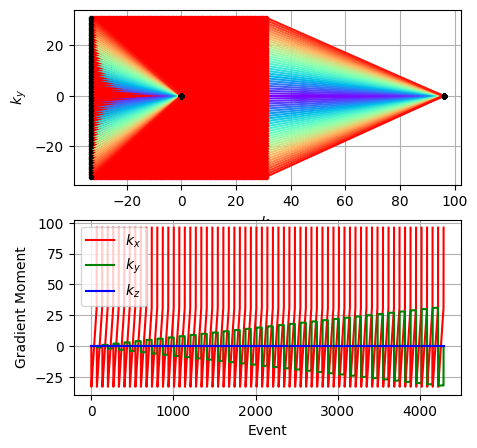

In [239]:
# Build the default FLASH and show the kspace
seq = build_seq()
seq.plot_kspace_trajectory()

# Until now, the sequence uses normalized grads: The simulation will adapt them
# to the phantom size. If we want to hardcode a fixed FOV instead, we can do so:
seq.normalized_grads = False
for rep in seq:
    rep.gradm[:] /= 200e-3  # 200 mm FOV

VoxelGridPhantom
size = tensor([0.1500, 0.1500, 1.0000])


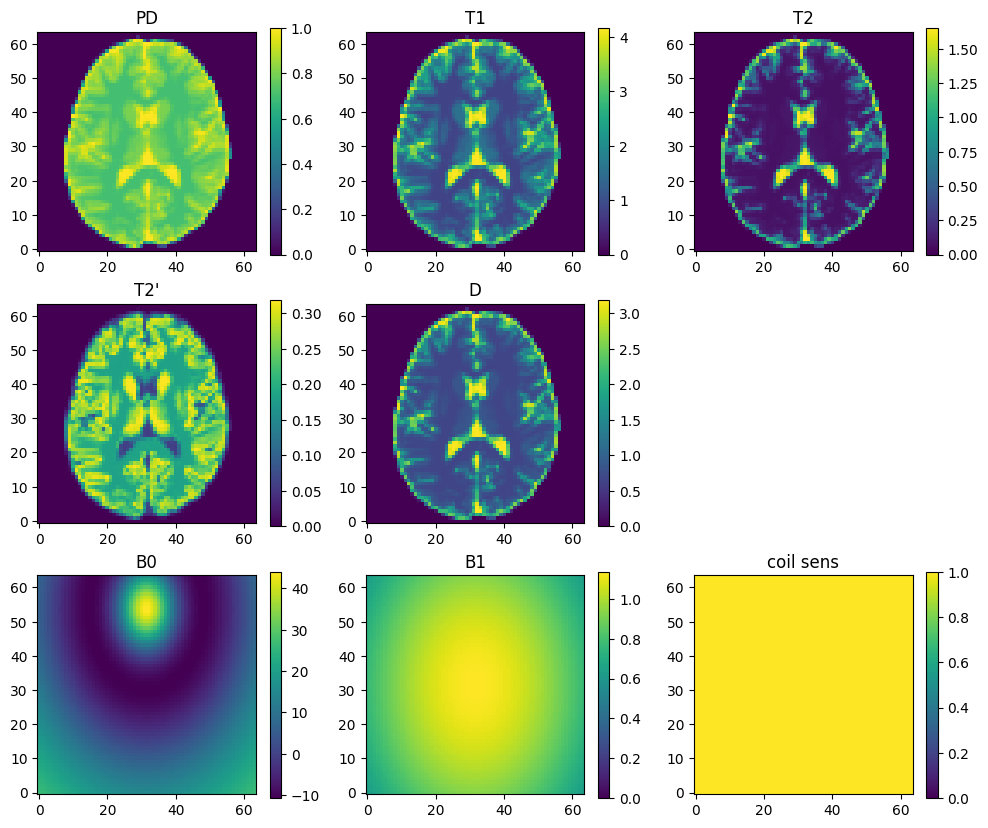

In [240]:
# Load a BrainWeb phantom for simulation

# https://github.com/MRsources/MRzero-Core/raw/main/documentation/examples/subject05.npz

phantom = mr0.VoxelGridPhantom.brainweb("subject05.npz")
phantom = phantom.interpolate(64, 64, 32).slices([16])
# The default fov is loaded from the data, but we can change it:
phantom.size = torch.tensor([0.15, 0.15, 1])

phantom.plot()
data = phantom.build()


def phantom_motion(time: torch.tensor) -> tuple[torch.tensor, torch.tensor]:
    time /= 0.712  # Sequence duration

    phi = 0.8 * time
    x = -0.03 * time**2
    y = 0 * time

    phi = torch.as_tensor(phi)
    cos = torch.cos(phi)
    sin = torch.sin(phi)

    # We can't construct tensors directly as this would remove gradients
    offset = torch.zeros(time.numel(), 3)
    offset[:, 0] = x
    offset[:, 1] = y

    rot = torch.zeros(time.numel(), 3, 3)
    rot[:, 0, 0] = cos
    rot[:, 0, 1] = sin
    rot[:, 1, 0] = -sin
    rot[:, 1, 1] = cos
    rot[:, 2, 2] = 1

    return rot, offset


data.phantom_motion = phantom_motion

In [241]:
# Simulate the sequence

graph = mr0.compute_graph(seq, data)
signal = mr0.execute_graph(graph, seq, data)
reco = mr0.reco_adjoint(signal, seq.get_kspace())

Calculating repetition 64 / 64 - done
Detected FOV: (0.2, 0.2, 1.0)
Detected resolution: (64, 64, 1)


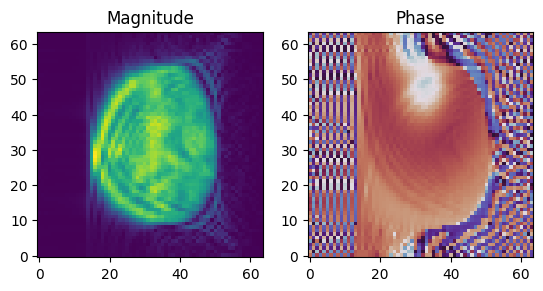

In [242]:
# Plot the result

plt.figure()
plt.subplot(121)
plt.title("Magnitude")
plt.imshow(reco.abs().cpu()[:, :, 0].T, origin='lower', vmin=0)
plt.subplot(122)
plt.title("Phase")
import numpy as np
plt.imshow(reco.angle().cpu()[:, :, 0].T, origin='lower', vmin=-np.pi, vmax=np.pi, cmap="twilight")
plt.show()

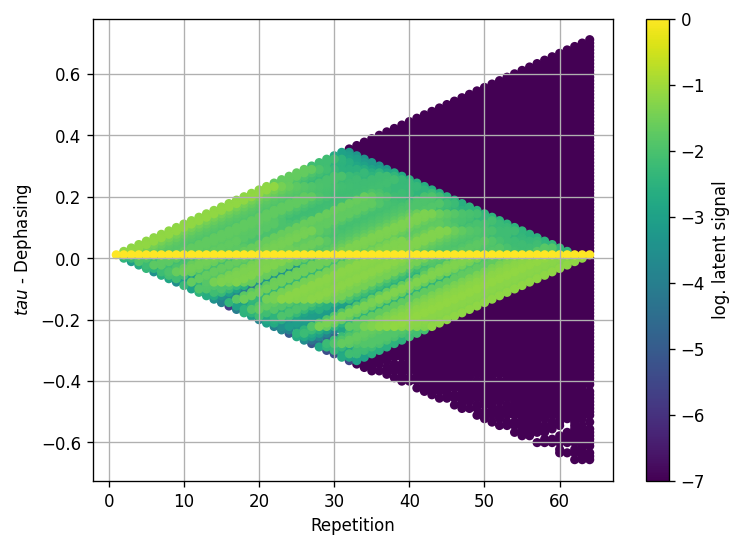

In [243]:
plt.figure(figsize=(7, 5), dpi=120)
graph.plot()
plt.grid()
plt.show()